Intern: Violette Renneville  
Supervisor: Sandrine Vinatier  
03 march - 27 june 2025

Seignovert et al. - PyVIMS (Version 1.0.5) - Zenodo

<center><span style="font-size:35px;">Overlay of CIRS FP1 and FP4 Footprints on VIMS and Radar Polar Projections</span></center>
<center><span style="font-size:20px;">M2 Internship – Analysis of Potential Cloud in Titan's Atmosphere</span></center>

This notebook was developed during my M2 internship to investigate potential cloud overlap with the Cassini/CIRS data in Titan's atmosphere. The goal is to overlay the footprints of CIRS instrument observations (focal planes FP1 and FP4) on a background composed of:
- Radar polar projection (highlighting Titan's lakes and seas)
- Cassini/VIMS cube, using false-color schemes based on Brown et al. (to highlight the troposphere and methane clouds)

This overlay allows us to estimate whether the CIRS measurements might have intersected atmospheric methane clouds — even though CIRS and VIMS did not operate simultaneously. This visual comparison provides a qualitative insight into potential cloud signal in CIRS data.


In [ ]:
# Install required dependencies (only needed once, or in fresh environments)
%pip install -r requirements.txt

# Table of Contents

1. [Importation](#1.-Importation)
2. [Distance per Degree of Latitude on Titan](#2.-Distance-per-Degree-of-Latitude-on-Titan)
3. [Load and Process CIRS Spectra for FP1 and FP4](#3.-Load-and-Process-CIRS-Spectra-for-FP1-and-FP4)
4. [Overlay of CIRS FP1 and FP4 Footprints on Titan Radar Map](#4.-Overlay-of-CIRS-FP1-and-FP4-Footprints-on-Titan-Radar-Map)
5. [Selection and Visualisation of VIMS Cube](#5.-Selection-and-Visualisation-of-VIMS-Cube)
6. [Overlay of CIRS FP1 & FP4 on VIMS Cube](#6.-Overlay-of-CIRS-FP1-&-FP4-on-VIMS-Cube)

### 1. Importation

In [1]:
#Import librairies

# --- Core libraries ---
import numpy as np
import pandas as pd
from pathlib import Path

# --- Jupiter dipslay ---
from PIL import Image
from IPython.display import display_html

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# --- Pyvims, specific VIMS librairies ---
# by Seignovert et al. - PyVIMS (Version 1.0.5) - Zenodo 
from pyvims import VIMS
from pyvims.misc import Map
from pyvims.wget import wget

### 2. Distance per Degree of Latitude on Titan

This calculation estimates the distance corresponding to 1° of latitude on Titan, assuming a spherical radius of 2,575.5 km.

In [2]:
# Titan's mean radius in kilometers
titan_radius_km = 2575.5  # km

# Distance corresponding to 1 degree of latitude (circumference divided by 360)
lat_Titan = (2 * np.pi * titan_radius_km) / 360

# Display result
print(f"1° of latitude on Titan ≈ {lat_Titan:.2f} km")


1° of latitude on Titan ≈ 44.95 km


In [3]:
#Load the Radar image of Titan
background_image_path = Path("data/Titan_Radar.jpg")
img = Image.open(background_image_path)

In [4]:
#CIRS data 
directory= Path("data/")

flyby_CIRS= 'T120'
# #T120
filename_FP1 = 'T120_FP1_60N_220W_v435_0p5.txt'
filename_FP4 = 'T120_FP4_75N_220W_v435_0p5.txt'

### 3. Load and Process CIRS Spectra for FP1 and FP4

This section loads the CIRS spectra from ASCII files, converts the range data into physical footprint sizes (in km and degrees), and prepares them for projection.

In [5]:
#Read spectra

#--------------------------FP1-----------------------------------------------
Data_FP1 = pd.read_csv(directory / filename_FP1, skiprows=2, sep='\s+', header=0, usecols=[1, 5, 6])
Data_FP1.rename(columns={Data_FP1.columns[2]: 'longitude'}, inplace=True)
nb_spe_FP1 = int(Data_FP1['latitude'].shape[0])

# Convert the 'range' column to numeric, coercing errors to NaN
Data_FP1['range (km)'] = pd.to_numeric(Data_FP1['range'], errors='coerce')

# Check for NaN in 'range'
if Data_FP1['range (km)'].isna().any():
    print("Attention : NaN are present in 'range'.")

Data_FP1['radius (km)'] = Data_FP1['range (km)'] * np.tan((3.9* 1e-3/2)) #FP1 3.9 mrad is the focal openning of FP1

Data_FP1['radius[°]'] = Data_FP1['radius (km)'] / lat_Titan  # Conversion in degree

#--------------------------FP4-----------------------------------------------

Data_FP4 = pd.read_csv(directory / filename_FP4, skiprows=2, sep='\s+', header=0, usecols=[1, 5, 6])
Data_FP4.rename(columns={Data_FP4.columns[2]: 'longitude'}, inplace=True)
nb_spe_FP4 = int(Data_FP4['latitude'].shape[0])

# Convert the 'range' column to numeric, coercing errors to NaN
Data_FP4['range (km)'] = pd.to_numeric(Data_FP4['range'], errors='coerce')

# Check for Nan in 'range'
if Data_FP4['range (km)'].isna().any():
    print("Attention : NaN are present in 'range'.")

Data_FP4['radius (km)'] = Data_FP4['range (km)'] * np.tan((0.27* 1e-3/2)) #FP4, 0.27mrad is the focal openning of FP4

Data_FP4['radius[°]'] = Data_FP4['radius (km)'] / lat_Titan  # Conversion in degree

Attention : NaN are present in 'range'.
Attention : NaN are present in 'range'.


This section computes and displays some basic statistics (number of spectra, min/max latitudes) for the FP1 and FP4 datasets, and shows the first 10 rows of both datasets side by side.

In [6]:
# Display number of spectra and latitude range for FP1
print(f"FP1 contains {nb_spe_FP1} spectra")
min_latitude_FP1 = Data_FP1[Data_FP1['latitude'] >= 1]['latitude'].min()
max_latitude_FP1 = Data_FP1['latitude'].max()
print(f"The minimum latitude is {min_latitude_FP1:.2f} and the maximum latitude is {max_latitude_FP1:.2f}.")

# Display number of spectra and latitude range for FP4
print(f"FP4 contains {nb_spe_FP4} spectra")
min_latitude_FP4 = Data_FP4[Data_FP4['latitude'] >= 1]['latitude'].min()
max_latitude_FP4 = Data_FP4['latitude'].max()
print(f"The minimum latitude is {min_latitude_FP4:.2f} and the maximum latitude is {max_latitude_FP4:.2f}.")

# Number of rows to display
nb_lines = 10  # Number of rows to display

# Function to display DataFrames side by side
def display_side_by_side(*args, titles=()):
    html_str = ''
    for i, df in enumerate(args):
        title = titles[i] if i < len(titles) else ''
        html_str += f'<div style="display:inline-block; vertical-align:top; margin-right:30px;">'
        if title:
            html_str += f'<h4>{title}</h4>'
        html_str += df.head(nb_lines).to_html(float_format="{:.2f}".format)
        html_str += '</div>'
    display_html(html_str, raw=True)

# Display FP1 and FP4 data side by side
display_side_by_side(Data_FP1, Data_FP4, titles=['Data_FP1', 'Data_FP4'])


FP1 contains 237 spectra
The minimum latitude is 60.60 and the maximum latitude is 61.20.
FP4 contains 1177 spectra
The minimum latitude is 75.50 and the maximum latitude is 84.10.


,range,latitude,longitude,range (km),radius (km),radius[°]
0,182515.,60.80,220.00,182515.00,355.90,7.92
1,182787.,60.70,220.00,182787.00,356.44,7.93
2,183060.,60.80,220.10,183060.00,356.97,7.94
3,183877.,60.80,219.80,183877.00,358.56,7.98
4,184149.,60.80,219.80,184149.00,359.09,7.99
5,184421.,60.80,220.00,184421.00,359.62,8.00
6,184694.,60.70,219.80,184694.00,360.15,8.01
7,184966.,60.60,220.20,184966.00,360.68,8.02
8,185239.,60.70,220.30,185239.00,361.22,8.04
9,185511.,60.60,220.00,185511.00,361.75,8.05


### 4. Overlay of CIRS FP1 and FP4 Footprints on Titan Radar Map

This section creates a figure that overlays the CIRS FP1 and FP4 footprints on a radar map of Titan. The footprints are represented by circles, and the figure includes color-coded circles for FP1 and FP4, with a transparent background to show the radar map. The map highlights Titan's surface features.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


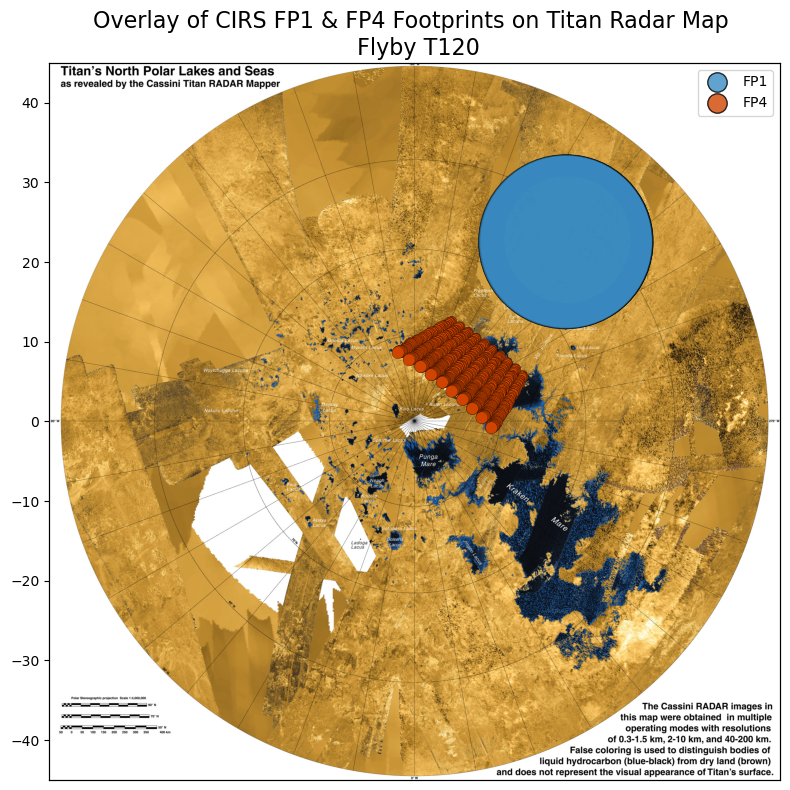

In [7]:
# Create the figure
fig, ax_img = plt.subplots(figsize=(8, 8))

# Define colors for the circles
colors_b = cm.Blues(np.linspace(0.5, 0.8, 5))
colors_o = cm.Oranges(np.linspace(0.5, 0.9, 7))
c_FP1 = colors_b[2]  # Color for FP1
c_FP4 = colors_o[4]  # Color for FP4

# Display the background image (Radar map of Titan)
ax_img.imshow(img, extent=[-45, 45, -45, 45], aspect='auto')  # Image with auto aspect ratio
ax_img.set_xlim(-45, 45)
ax_img.set_ylim(-45, 45)

# Add a second axis on top for plotting the circles
ax_circles = ax_img.twinx()  # Overlay an axis
ax_circles.set_xlim(-45, 45)
ax_circles.set_ylim(-45, 45)
ax_circles.set_aspect('equal')  # Force equal aspect for circles

#---------------------FP1----------------------------
# Calculate the coordinates of the circles for FP1
long_FP1 = 90 - Data_FP1['longitude']
lat_FP1 = Data_FP1['latitude'] - 90
r_FP1 = Data_FP1['radius[°]']
x_FP1 = lat_FP1 * np.cos(np.radians(long_FP1))
y_FP1 = lat_FP1 * np.sin(np.radians(long_FP1))

circles_FP1 = [Circle((x_FP1.iloc[i], y_FP1.iloc[i]), r_FP1.iloc[i]) for i in range(len(x_FP1))]

# Circle collection for FP1 with customized border transparency and thinner border
circle_collection_FP1 = PatchCollection(
    circles_FP1,
    color=c_FP1,
    alpha=0.3,
    edgecolor=(0, 0, 0, 0.2),  # Transparent black border
    linewidth=0.7,             # Thinner border
    label='FP1'
)
ax_circles.add_collection(circle_collection_FP1)

#---------------------FP4----------------------------
# Calculate the coordinates of the circles for FP4
long_FP4 = 90 - Data_FP4['longitude']
lat_FP4 = Data_FP4['latitude'] - 90
r_FP4 = Data_FP4['radius[°]']
x_FP4 = lat_FP4 * np.cos(np.radians(long_FP4))
y_FP4 = lat_FP4 * np.sin(np.radians(long_FP4))

circles_FP4 = [Circle((x_FP4.iloc[i], y_FP4.iloc[i]), r_FP4.iloc[i]) for i in range(len(x_FP4))]

# Circle collection for FP4 with customized border transparency and thinner border
circle_collection_FP4 = PatchCollection(
    circles_FP4,
    color=c_FP4,
    alpha=0.9,
    edgecolor=(0, 0, 0, 0.2),  # Transparent black border
    linewidth=0.2,             # Thinner border
    label='FP4'
)
ax_circles.add_collection(circle_collection_FP4)

# Add a legend for FP1 and FP4
handles = [
    Line2D([0], [0], marker='o', color='w', label='FP1', markerfacecolor=c_FP1, markersize=14, alpha=0.8, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='FP4', markerfacecolor=c_FP4, markersize=14, alpha=0.8, markeredgecolor='black')
]
ax_circles.legend(handles=handles, loc='upper right')

# Remove ticks from the second axis to avoid duplication
ax_circles.set_xticks([])
ax_circles.set_yticks([])

# Add a title
plt.title(f"Overlay of CIRS FP1 & FP4 Footprints on Titan Radar Map \n Flyby {flyby_CIRS}", fontsize=16)
plt.tight_layout()

# Show the figure
plt.show()

# Optionally save the figure
# fig.savefig(f"{flyby_CIRS}_{FP}.png", dpi=300, bbox_inches='tight')


### 5. Selection and visualisation of VIMS Cube

In [8]:
#Load the VIMS cube with its number, named later by its flyby.

cube01= VIMS('1844022476_1 ')#Better T120

cube=cube01
num=cube
flyby=cube.flyby

In [9]:
#Selection of RGB bands from Le Mouélic et al (2019) and Brown et al (2010)
surf= '165:171' #surface
tropo='211:230' #tropsphere
strato='177:201' #stratosphere

c:\Users\Marc Renneville\anaconda3\envs\stageM2\lib\site-packages\pyvims\img.py:32: RuntimeWarning: invalid value encountered in cast
  return np.uint8(np.clip(255 * (img - imin) / (imax - imin), 0, 255))


<Figure size 640x480 with 0 Axes>

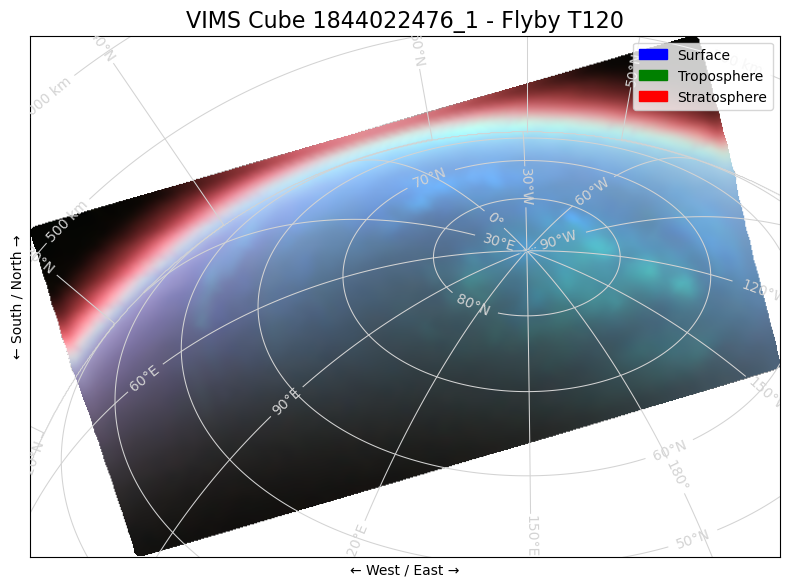

In [10]:
#Display the VIMS cube in an orthogonal projection
plt.figure()
ax = (cube01.plot((strato, tropo, surf), 'ortho'));

#Legend
surf_nantes_patch = mpatches.Patch(color='red', label='Stratosphere')
tropo_nantes_patch = mpatches.Patch(color='green', label='Troposphere')
strato_nantes_patch = mpatches.Patch(color='blue', label='Surface')
legend_handles = [
    strato_nantes_patch,
    tropo_nantes_patch,
    surf_nantes_patch
]
ax.legend(handles=legend_handles, loc='upper right')

plt.title(f"VIMS Cube {num} - Flyby {flyby}", fontsize=16)
plt.tight_layout()

### 6. Overlay of CIRS FP1 & FP4 on VIMS Cube

This section overlays the CIRS FP1 and FP4 footprints on a VIMS cube, plotting them in a polar projection. The footprints are represented as circles, and the legend highlights the different regions of the atmosphere (Stratosphere, Troposphere, and Surface). The troposphere in greenish is considered as methane clouds. The VIMS data are plotted in the background.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


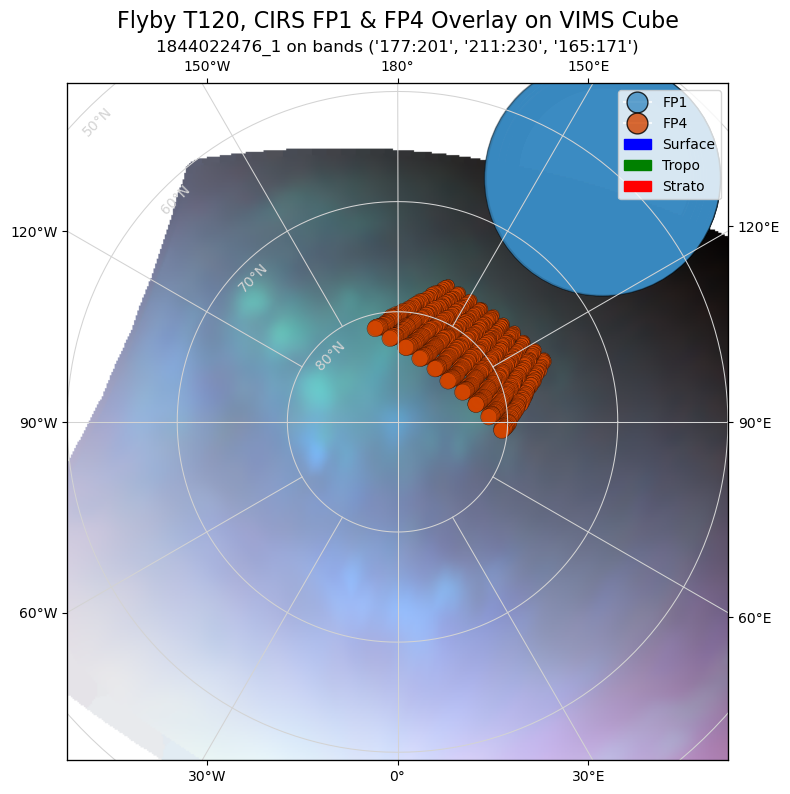

In [11]:
# Create a figure for the VIMS cube with overlay
plt.figure()
ax = (cube01.plot((strato, tropo, surf), 'polar'))

#---------------------FP1----------------------------
# Calculate the coordinates of the circles for FP1
long_FP1 = Data_FP1['longitude'] + 270
lat_FP1 = Data_FP1['latitude'] - 90
r_FP1 = Data_FP1['radius[°]']
x_FP1 = lat_FP1 * np.cos(np.radians(long_FP1))
y_FP1 = lat_FP1 * np.sin(np.radians(long_FP1))

# Create circle objects for FP1
circles_FP1 = [Circle((x_FP1.iloc[i], y_FP1.iloc[i]), r_FP1.iloc[i]) for i in range(len(x_FP1))]

# Circle collection for FP1 with customized border transparency and thinner border
circle_collection_FP1 = PatchCollection(
    circles_FP1,
    color=c_FP1,
    alpha=0.3,
    edgecolor=(0, 0, 0, 0.5),  # Transparent black border
    linewidth=0.5,             # Thinner border
    label='FP1'
)
ax.add_collection(circle_collection_FP1)

#---------------------FP4----------------------------
# Calculate the coordinates of the circles for FP4
long_FP4 = Data_FP4['longitude'] + 270
lat_FP4 = Data_FP4['latitude'] - 90
r_FP4 = Data_FP4['radius[°]']
x_FP4 = lat_FP4 * np.cos(np.radians(long_FP4))
y_FP4 = lat_FP4 * np.sin(np.radians(long_FP4))

# Create circle objects for FP4
circles_FP4 = [Circle((x_FP4.iloc[i], y_FP4.iloc[i]), r_FP4.iloc[i]) for i in range(len(x_FP4))]

# Circle collection for FP4 with customized border transparency and thinner border
circle_collection_FP4 = PatchCollection(
    circles_FP4,
    color=c_FP4,
    alpha=0.8,
    edgecolor=(0, 0, 0, 0.5),  # Transparent black border
    linewidth=0.2,             # Thinner border
    label='FP4'
)
ax.add_collection(circle_collection_FP4)

# Create custom legend patches for the different regions (Strato, Tropo, Surface)
surf_nantes_patch = mpatches.Patch(color='red', label='Strato')
tropo_nantes_patch = mpatches.Patch(color='green', label='Tropo')
strato_nantes_patch = mpatches.Patch(color='blue', label='Surface')

# Use custom handles with circles for the FP1 and FP4 legends
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='FP1', markerfacecolor=c_FP1, markersize=15, alpha=0.8, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='FP4', markerfacecolor=c_FP4, markersize=15, alpha=0.8, markeredgecolor='black'),
    strato_nantes_patch,
    tropo_nantes_patch,
    surf_nantes_patch
]

# Add the legend to the plot
ax.legend(handles=legend_handles, loc='upper right')

# Add the title to the plot
plt.title(f"Flyby {flyby}, CIRS FP1 & FP4 Overlay on VIMS Cube", y=1.07, fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Optionally save the figure (commented out for now)
# fig = ax.get_figure()
# fig.savefig(f"{flyby_CIRS}_{FP}_VIMS.png", dpi=300, bbox_inches='tight')


Violette Renneville - July 2025.